# 0.0 IMPORTS FUNCTIONS AND CONNECTION

## 0.1 Packages and Libraries

In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import inflection

from matplotlib import pyplot as plt

from IPython.core.display import HTML
from IPython.display import Image

## 0.2 Helper Functions

In [58]:
warnings.filterwarnings ('ignore')

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:90% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [59]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.3 Database Load

In [60]:
df_raw = pd.read_csv('data/raw/churn.csv')
df_raw.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# 1.0 DATA DESCRIPTION

In [61]:
df1 = df_raw.copy()

## 1.1 Dimensão dos Dados

In [62]:
print(f'Número de Linhas: {df1.shape[0]}')
print(f'Número de Colunas: {df1.shape[1]}')

Número de Linhas: 10000
Número de Colunas: 14


## 1.2 Renomeação de Colunas

In [63]:
cols_old = ['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

In [64]:
df1.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

## 1.3 Tipagem dos Dados

In [65]:
df1.dtypes

row_number            int64
customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

## 1.4 Check NA

In [66]:
df1.isna().sum()

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

## 1.5 Métricas de Descrição Geral dos dados

In [67]:
df1_num = df1.select_dtypes(include=['int64', 'float64'])
df1_cat = df1.select_dtypes(exclude=['int64', 'float64'])

#Métricas de tendência central - média, mediana
ct1 = pd.DataFrame(df1_num.apply(np.mean)).T
ct2 = pd.DataFrame(df1_num.apply(np.median)).T

#Métricas de dispersão - min, max, range, desvio padrão (std) skew, kurtosis

d1 = pd.DataFrame(df1_num.apply(min)).T
d2 = pd.DataFrame(df1_num.apply(max)).T
d3 = pd.DataFrame(df1_num.apply(lambda x: x.max() - x.min())).T
d4 = pd.DataFrame(df1_num.apply(np.std)).T
d5 = pd.DataFrame(df1_num.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(df1_num.apply(lambda x: x.kurtosis())).T

df_desc = pd.concat([d1, d2, d3, ct1, ct2, d4, d5, d6]).T.reset_index().round(2)
df_desc.columns = ['attributes','min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
df_desc

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,row_number,1.00,10000.00,9999.00,5000.50,5000.50,2886.75,0.00,-1.20
1,customer_id,15565701.00,15815690.00,249989.00,15690940.57,15690738.00,71932.59,0.00,-1.20
2,credit_score,350.00,850.00,500.00,650.53,652.00,96.65,-0.07,-0.43
3,age,18.00,92.00,74.00,38.92,37.00,10.49,1.01,1.40
4,tenure,0.00,10.00,10.00,5.01,5.00,2.89,0.01,-1.17
5,balance,0.00,250898.09,250898.09,76485.89,97198.54,62394.29,-0.14,-1.49
6,num_of_products,1.00,4.00,3.00,1.53,1.00,0.58,0.75,0.58
7,has_cr_card,0.00,1.00,1.00,0.71,1.00,0.46,-0.90,-1.19
8,is_active_member,0.00,1.00,1.00,0.52,1.00,0.50,-0.06,-2.00
9,estimated_salary,11.58,199992.48,199980.90,100090.24,100193.92,57507.62,0.00,-1.18


In [68]:
df1_cat.apply(lambda x: x.unique().shape[0]) 

surname      2932
geography       3
gender          2
dtype: int64

In [69]:
df1[['row_number', 'surname']].groupby('surname').count().sort_values('row_number', ascending=False).reset_index().head()

,surname,row_number
0,Smith,32
1,Martin,29
2,Scott,29
3,Walker,28
4,Brown,26


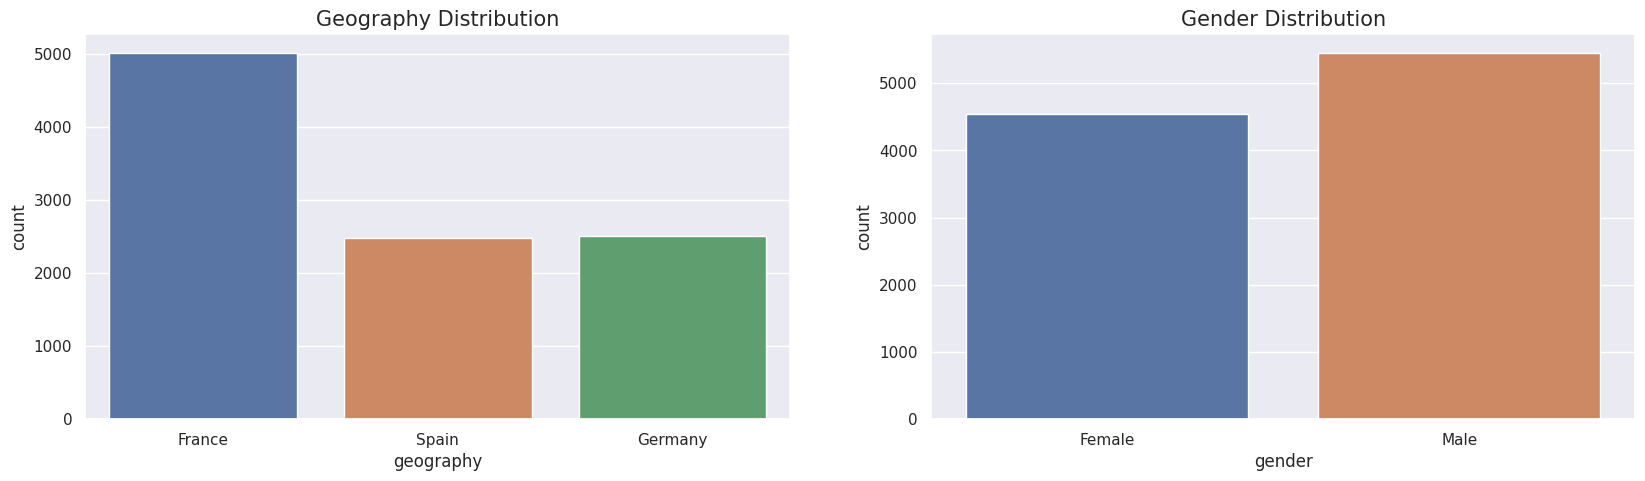

In [70]:
plt.figure(figsize=(20,5))
plt.subplot2grid((1,2), (0,0))
plt.subplot2grid((1,2), (0,1))

plt.subplot(1, 2, 1)
plt.title('Geography Distribution', fontsize=15)
sns.countplot(df1, x='geography');

plt.subplot(1, 2, 2)
plt.title('Gender Distribution', fontsize=15)
sns.countplot(df1, x='gender');

# 2.0 Feature Engineering

In [71]:
df2 = df1.copy()

reorder_columns = ['row_number', 'customer_id', 'surname', 'geography',
       'gender', 'age','has_cr_card', 'credit_score', 'tenure', 'balance',
       'is_active_member', 'estimated_salary', 'num_of_products', 'exited']

df2 = df2.reindex(columns=reorder_columns)

In [72]:
df2.columns

Index(['row_number', 'customer_id', 'surname', 'geography', 'gender', 'age',
       'has_cr_card', 'credit_score', 'tenure', 'balance', 'is_active_member',
       'estimated_salary', 'num_of_products', 'exited'],
      dtype='object')

## 2.1 Mindmap de Hipóteses

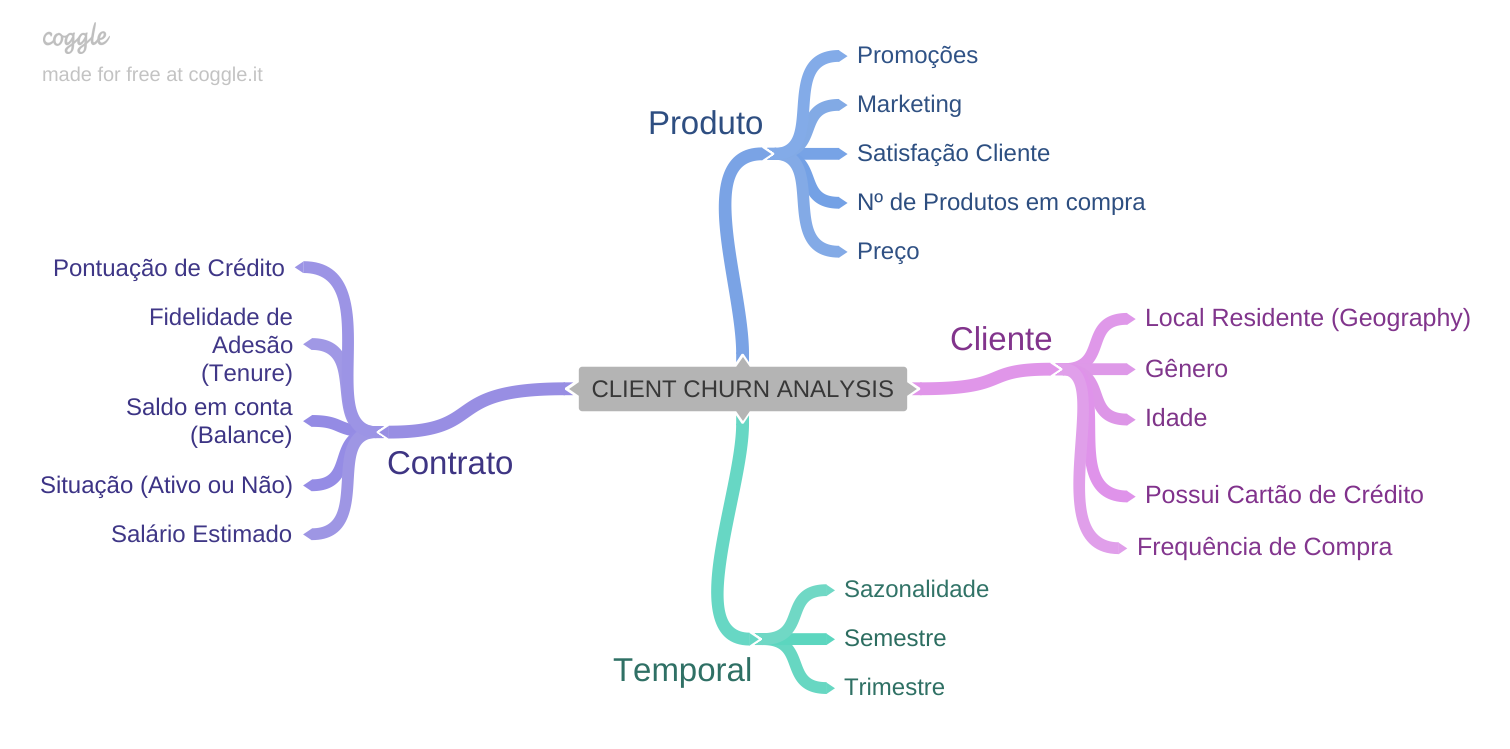

In [73]:
Image('img/churn_analysis.png')

### 2.1.1  Lista de Hipóteses sobre Clientes

    1.Clientes de determinada região são mais propensos a entrarem em churn.
    2.Clientes de determinado gênero(sexo) são mais propensos a entrarem em churn.
    3.Clientes mais velhos são mais propensos a entrarem em churn.
    4.Clientes que possuem o cartão de crédito da loja são menos propensos a entrarem em churn.
    5.Clientes que compram mais frequentemente são menos propensos de entrarem em churn.

### 2.1.2 Lista de Hipóteses de Contrato

    1.Contratos com maiores pontuações de crédito são menos propensos a entrarem em churn.
    2.Contratos com alta fidelidade de adesão são menos propensos a entrarem em churn.
    3.Contratos que indicam saldos maiores em conta são menos propensos a entrarem em churn.
    4.Contratos que indicam situação ativa na compra dos produtos são menos propensos a entrarem em churn.
    5.Contratos que estimam maiores salários do cliente são menos propensos a entrarem em churn.

### 2.1.3 Lista de Hipóteses de Produto

    1. Produtos com promoções mais frequentes evitam o churn de contrato/cliente.
    2. Marketing mais ostensivo evitam o churn de contrato/cliente.
    3. Alto índice de satisfação do cliente com o serviço/produto reduzem a probabilidade de churn.
    4. Contratos feitos com maior nº de produtos comprados tendem a ter menor probabilidade de churn.
    5. Produtos mais caros tendem a gerar contratos com maior probabilidade de churn.

### 2.1.4 Lista de Hipóteses relacionadas ao Tempo

    1. Clientes tendem a entrar em churn em determinado mês/bimestre/trimestre/semestre/etc.

## 2.2 Lista Final de Hipóteses

    1.Clientes de determinada região são mais propensos a entrarem em churn.
    2.Clientes de determinado gênero(sexo) são mais propensos a entrarem em churn.
    3.Clientes mais velhos são mais propensos a entrarem em churn.
    4.Clientes que possuem o cartão de crédito da loja são menos propensos a entrarem em churn.
    5.Contratos com maiores pontuações de crédito são menos propensos a entrarem em churn.
    6.Contratos com alta fidelidade de adesão são menos propensos a entrarem em churn.
    7.Contratos que indicam saldos maiores em conta são menos propensos a entrarem em churn.
    8.Contratos que indicam situação ativa na compra dos produtos são menos propensos a entrarem em churn.
    9.Contratos que estimam maiores salários do cliente são menos propensos a entrarem em churn.
    10.Contratos feitos com maior nº de produtos comprados tendem a ter menor probabilidade de churn.
    

# 3.0 DATA RAZORING

In [80]:
df3 = df2.copy()

In [81]:
df3 = df3.drop('surname', axis=1).head()
#A coluna sobrenome (surname) não trará aprendizado ao modelo

In [82]:
df3.head()

,row_number,customer_id,geography,gender,age,has_cr_card,credit_score,tenure,balance,is_active_member,estimated_salary,num_of_products,exited
0,1,15634602,France,Female,42,1,619,2,0.00,1,101348.88,1,1
1,2,15647311,Spain,Female,41,0,608,1,83807.86,1,112542.58,1,0
2,3,15619304,France,Female,42,1,502,8,159660.80,0,113931.57,3,1
3,4,15701354,France,Female,39,0,699,1,0.00,0,93826.63,2,0
4,5,15737888,Spain,Female,43,1,850,2,125510.82,1,79084.10,1,0
